In [15]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

In [16]:
# load data and drop unnecessary columns

dc_listings = pd.read_csv('dc_airbnb.csv')
keep_col = ['accommodates','bedrooms','bathrooms','beds','price','number_of_reviews']
dc_listings = dc_listings[keep_col]
print(dc_listings.shape)

dc_listings.head()

(3723, 6)


,accommodates,bedrooms,bathrooms,beds,price,number_of_reviews
0,4,1.0,1.0,2.0,$160.00,0
1,6,3.0,3.0,3.0,$350.00,65
2,1,1.0,2.0,1.0,$50.00,1
3,2,1.0,1.0,1.0,$95.00,0
4,4,1.0,1.0,1.0,$50.00,0


In [17]:
# eliminate the $ from price column and drop rows with NaN

dc_listings['price'] = dc_listings.price.str.replace("\$|,",'').astype(float)
dc_listings.dropna(inplace=True)
print(dc_listings.shape)
null_counts = dc_listings.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

dc_listings.head()

(3671, 6)
Number of null values in each column:
accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
number_of_reviews    0
dtype: int64


,accommodates,bedrooms,bathrooms,beds,price,number_of_reviews
0,4,1.0,1.0,2.0,160.0,0
1,6,3.0,3.0,3.0,350.0,65
2,1,1.0,2.0,1.0,50.0,1
3,2,1.0,1.0,1.0,95.0,0
4,4,1.0,1.0,1.0,50.0,0


In [19]:
# initialize the knn system = predict price for acc == 3
# looking for a place for 3 people
our_acc_value = 3 # living place accommodates 3 people

# get me this column
first_living_space_value = dc_listings.loc[0,'accommodates']

# find the difference abs(x-3)
first_distance = np.abs(first_living_space_value-our_acc_value)
print(first_distance)

1


In [20]:
# create a column with distance == 3
dc_listings['distance']=np.abs(dc_listings.accommodates-our_acc_value)
dc_listings.distance.value_counts().sort_index()

0      457
1     2258
2      497
3      276
4       35
5       73
6       17
7       22
8        7
9        9
10       2
11       4
12       6
13       8
Name: distance, dtype: int64

In [180]:
# can't choose the first 5 = shuffle first = then take the first 5
dc_listings = dc_listings.sample(frac=1,random_state=0) # reproducible random order
dc_listings = dc_listings.sort_values('distance')
dc_listings.price

577      185.0
823      139.0
3413     125.0
409      128.0
2432     125.0
86       400.0
3261      98.0
1444      92.0
341      209.0
3626     175.0
2293     105.0
2835     171.0
108       89.0
164      120.0
976       95.0
3707     135.0
2199     100.0
1604     120.0
1097     200.0
1281     200.0
2044     134.0
376       96.0
2125     149.0
899      200.0
952      150.0
1330     135.0
1823      76.0
3328      57.0
453      207.0
2495      99.0
         ...  
660      298.0
808      215.0
3305    2000.0
1656     283.0
2995     595.0
3272     599.0
542      340.0
529      600.0
1885      99.0
1326     375.0
571      720.0
3524     295.0
1658     283.0
1403     599.0
562      599.0
685      399.0
2688     749.0
1806     330.0
657      500.0
1850     180.0
2757     245.0
2106     499.0
611     1250.0
2560      60.0
1224     499.0
1596     299.0
1818      10.0
1402    1200.0
763     1000.0
1594    1250.0
Name: price, Length: 3671, dtype: float64

In [181]:
# example of single prediction
k = 5
mean_price = dc_listings.price.iloc[:5].mean()
mean_price

140.4

In [316]:
# divide train and test data
factor = 0.9
total_data = int(3671*factor)
train_number = int(total_data*0.8)
test_number = int(total_data*0.2)
dc_listings.drop('distance',axis=1)

train_df = dc_listings.copy().iloc[:train_number]
test_df = dc_listings.copy().iloc[train_number:train_number+test_number]
print(train_df.shape,test_df.shape)

(2642, 7) (660, 7)


In [317]:
# function t
def predict_price(new_listing_value,feature_column):
    temp_df = train_df
    
    ## isn't it train_df ???
    temp_df['distance'] = np.abs(dc_listings[feature_column] - new_listing_value)
    temp_df = temp_df.sort_values('distance')
    knn_5 = temp_df.price.iloc[:5]
    predicted_price = knn_5.mean()
    return(predicted_price)

In [318]:
test_df['predicted_price'] = test_df.accommodates.apply(predict_price,feature_column='accommodates')

In [319]:
#using RMSE to evaluate our model - root mean squared error
test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)
mse = test_df['squared_error'].mean()
rmse = mse ** (1/2)
rmse

113.59804202324595

In [320]:
# Comparing different models
error = []
for feature in ['accommodates','bedrooms','bathrooms','number_of_reviews','beds']:
    test_df['predicted_price'] = test_df.accommodates.apply(predict_price,feature_column=feature)
    
    test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)
    mse = test_df['squared_error'].mean()
    rmse = mse ** (1/2)
    error.append(rmse)
    print("RMSE for the {} column: {}".format(feature,rmse))

RMSE for the accommodates column: 113.59804202324595
RMSE for the bedrooms column: 114.8922348827963
RMSE for the bathrooms column: 111.13731119382878
RMSE for the number_of_reviews column: 137.62059835253257
RMSE for the beds column: 114.618623480152


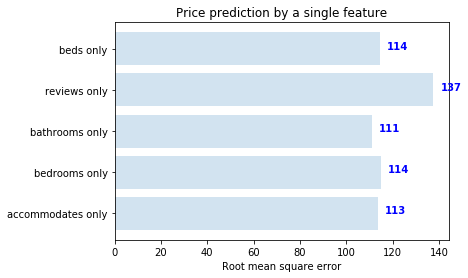

In [321]:
objects = ('accommodates only', 'bedrooms only', 'bathrooms only', 'reviews only', 'beds only')
y_pos = np.arange(len(objects))
plt.barh(y_pos, error, align='center', alpha=0.2)
plt.yticks(y_pos, objects)
plt.xlabel('Root mean square error')
plt.title('Price prediction by a single feature')


for i, v in enumerate(error):
    plt.text(v + 3, i, str(int(v)), color='blue', fontweight='bold')
 
plt.show()

In [322]:
for feature in ['accommodates','bedrooms','bathrooms','number_of_reviews','beds']:
    dc_listings[feature] = (dc_listings[feature]-dc_listings[feature].mean())/dc_listings[feature].std()

In [323]:
normalized_listings = dc_listings.sample(frac=1,random_state=0)

norm_train_df = dc_listings.copy().iloc[:train_number]
norm_test_df = dc_listings.copy().iloc[train_number:]

normalized_listings.shape
normalized_listings.head()

,accommodates,bedrooms,bathrooms,beds,price,number_of_reviews,distance
381,-0.596544,-0.249467,-0.439151,-0.546858,295.0,-0.516709,1
1191,-0.097589,-0.249467,-0.439151,-0.546858,199.0,0.030551,0
505,-0.596544,-0.249467,1.264998,-0.546858,110.0,-0.072060,1
472,-0.596544,-0.249467,-0.439151,-0.546858,350.0,-0.414097,1
3696,-0.596544,-0.249467,-0.439151,-0.546858,70.0,5.537355,1


In [324]:
from scipy.spatial import distance
def predict_price_multivariate(new_listing_value,feature_columns):
    temp_df = norm_train_df
    temp_df['distance'] = distance.cdist(temp_df[feature_columns],[new_listing_value[feature_columns]])
    temp_df = temp_df.sort_values('distance')
    knn_5 = temp_df.price.iloc[:5]
    predicted_price = knn_5.mean()
    return(predicted_price)

cols = ['accommodates','beds']
norm_test_df['predicted_price'] = norm_test_df[cols].apply(predict_price_multivariate,feature_columns=cols,axis=1)    
norm_test_df['squared_error'] = (norm_test_df['predicted_price'] - norm_test_df['price'])**(2)
mse = norm_test_df['squared_error'].mean()
two_features_rmse = mse ** (1/2)
print(rmse)
error.append(two_features_rmse)

114.618623480152


In [325]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
knn = KNeighborsRegressor()

knn = KNeighborsRegressor(algorithm='brute')

cols = ['accommodates','bedrooms','bathrooms','beds','number_of_reviews']

knn.fit(norm_train_df[cols], norm_train_df['price'])
all_features_predictions = knn.predict(norm_test_df[cols])
all_features_mse = mean_squared_error(norm_test_df['price'], all_features_predictions)
all_features_rmse = all_features_mse ** (1/2)
all_features_rmse
error.append(all_features_rmse)

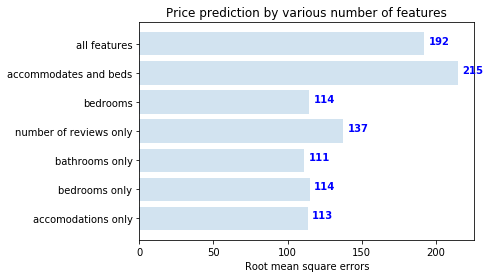

In [326]:
objects = ('accomodations only', 'bedrooms only', 'bathrooms only', 'number of reviews only',  'bedrooms', 'accommodates and beds','all features')
y_pos = np.arange(len(objects))
plt.barh(y_pos, error, align='center', alpha=0.2)
plt.yticks(y_pos, objects)
plt.xlabel('Root mean square errors')
plt.title('Price prediction by various number of features')

for i, v in enumerate(error):
    plt.text(v + 3, i, str(int(v)), color='blue', fontweight='bold')
 
plt.show()

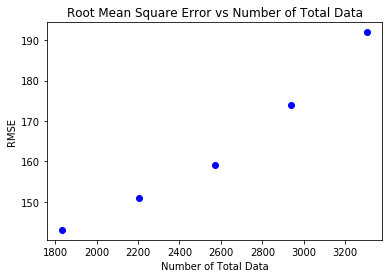

In [330]:
x = [0.5*3671,0.6*3671,0.7*3671,0.8*3671,0.9*3671]
y = [143,151,159,174,192]

plt.plot(x,y,'bo')
plt.title('Root Mean Square Error vs Number of Total Data')
plt.ylabel('RMSE')
plt.xlabel('Number of Total Data')
plt.show()

In [ ]:
x = [0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9]
y = [143,149,154,158,162,182,216,290]

plt.plot(x,y)
plt.title('Root Mean Square error vs Train/Total')
plt.ylabel('RMSE')
plt.xlabel('Train/Total')
plt.show()

In [331]:
dc_listings.shape

(3671, 7)

# The KNN algorithm by alone is not sufficient for high accuracy of Airbnb cost prediction. Also, only 3000 records of dataset can't result in a high accuracy. Different prediction models will be used in the later versions.